### Importing libraries

In [2]:
import numpy as np
import pandas as pd
import re
from datetime import datetime
import geopandas
from geopandas import GeoDataFrame, GeoSeries
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import matplotlib.cm as cm
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.rcParams["figure.figsize"] = [8,6]
import seaborn as sns
from shapely.geometry import Point, Polygon
from geopy.geocoders import Nominatim
import folium
from folium import plugins
import json 
import requests 
from pandas.io.json import json_normalize
print('Libraries imported.')

Libraries imported.


### <a id="scope">Project Scope Boundaries</a>

#### Getting Dublin city coordinates

In [2]:
address = 'Dublin, Ireland'

geolocator = Nominatim(user_agent="ie_explorer")
location = geolocator.geocode(address)
dub_latitude = location.latitude
dub_longitude = location.longitude
print('The geograpical coordinates of Dublin are {}, {}.'.format(dub_latitude, dub_longitude))

The geograpical coordinates of Dublin are 53.3497645, -6.2602732.


### Creating  a mesh of # points on top of Dublin city due to asymmetrical boroughs shape

#### Setting coordinates limit for a rectangular mesh 

In [3]:
# make a grid of latitude-longitude values
xmin, xmax, ymin, ymax = -6.295547, -6.227464, 53.322556, 53.356207
xx, yy = np.meshgrid(np.linspace(xmin,xmax,10), np.linspace(ymin,ymax,8))
xc = xx.flatten()
yc = yy.flatten()
#rounding coordinates to 6 decimals
xc = np.round_(xc, decimals=6)
yc = np.round_(yc, decimals=6)

In [4]:
# Now convert these points to Coordinates label
pts = GeoSeries([Point(x, y) for x, y in zip(xc, yc)])
coords = []
for n, point in enumerate(pts):
    coords += [', '.join(__ for __ in _.strip().split(' ')[::-1]) for _ in str(point).split('(')[1].split(')')[0].split(',')]


In [5]:
len(coords)

80

#### Merging  Longitude & Latitude lists into a Dataframe(dub_mesh)

In [6]:
df_lon = pd.DataFrame(xc, columns=['Longitude'])
df_lat = pd.DataFrame(yc, columns=['Latitude'])
df_coords = pd.DataFrame(coords, columns=['Coordinates'])
dub_mesh = pd.concat([df_lat, df_lon, df_coords], axis=1)

In [7]:
# create map of Dublin using latitude and longitude values
map_dublin = folium.Map(location=[dub_latitude, dub_longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(dub_mesh['Latitude'], dub_mesh['Longitude'], dub_mesh['Coordinates']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dublin)  
    
map_dublin

#### Removing coordinates on the corners to reduce the dataframe to # points

In [8]:
dm = dub_mesh.copy()
dm.shape

(80, 3)

In [9]:
Lati = 'Latitude'
Long = 'Longitude'

if dm.shape[0] == dub_mesh.shape[0]:
    i_11 = dm[ (dm[Lati] == dm[Lati].max()) & (dm[Long] == dm[Long].min())].index
    i_12 = dm[ (dm[Lati] == dm[Lati].max()) & (dm[Long] == dm[Long].max())].index
    i_21 = dm[ (dm[Lati] == dm[Lati].min()) & (dm[Long] == dm[Long].min())].index
    i_22 = dm[ (dm[Lati] == dm[Lati].min()) & (dm[Long] == dm[Long].max())].index
    dm.drop([i_11[0], i_12[0], i_21[0], i_22[0]], inplace=True)
    dm = dm.reset_index(drop=True)
    print('Dataframe has been reduced to {} points.'.format(dm.shape[0]))
else:
    print('Dataframe already has been already reduced!')

dm.shape

Dataframe has been reduced to 76 points.


(76, 3)

In [10]:
# create map of Dublin using latitude and longitude values
map_dub = folium.Map(location=[dub_latitude, dub_longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(dm['Latitude'], dm['Longitude'], dm['Coordinates']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dub)  
    
map_dub

In [11]:
def Get_address_raw(coordinates):
    geolocator = Nominatim(user_agent="ie_explorer")
    location = geolocator.reverse(coordinates)
    return  location.raw

In [12]:
space = '     ' 
i = 0
for i in range (0, len(dm)):
    raw = Get_address_raw(dm['Coordinates'][i])
    dm.loc[i, 'District'] = raw.get('address').get('city_district')
    dm.loc[i, 'PostCode'] = re.findall(r"Dublin \d+", raw.get('display_name'))[0]
    print ('{}, {} added to {}{}'.format(dm.loc[i, 'District'], dm.loc[i, 'PostCode'], dm.loc[i, 'Coordinates'], 10*space), end="\r", flush=True)
    
print ('All raws processed.{}'.format(10*space), end="\r", flush=True)

In [11]:
#dm.to_csv('CSVs/Dublin_mesh_76_dots.csv', index=False)

In [12]:
#dm = pd.read_csv('CSVs/Dublin_mesh_76_dots.csv')

In [15]:
dm.head()

Latitude  Longitude           Coordinates                       District  \
0  53.322556  -6.287982  53.322556, -6.287982                   Kimmage C ED   
1  53.322556  -6.280417  53.322556, -6.280417                   Kimmage C ED   
2  53.322556  -6.272853  53.322556, -6.272853            Rathmines West F ED   
3  53.322556  -6.265288  53.322556, -6.265288  Rathmines and Rathgar West ED   
4  53.322556  -6.257723  53.322556, -6.257723  Rathmines and Rathgar West ED   

   PostCode  
0  Dublin 6  
1  Dublin 6  
2  Dublin 6  
3  Dublin 6  
4  Dublin 6

In [14]:
dm.drop(columns=['Unnamed: 0'], inplace=True)

#### Define Foursquare Credentials and Version (once project completed API has been reset for best security practices)

In [16]:
# @hidden_cell
CLIENT_ID = 'IVXGIxxxxxxxxxxxxxxxxxxxxxxKLIJHRES' # your Foursquare ID
CLIENT_SECRET = '2U1SBWZxxxxxxxxxxxxxxxxxxxxxxxXSEIAUDJ' # your Foursquare Secret
ACCESS_TOKEN = 'ZPFYxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxOV3CI4IHT'
VERSION = '20200101' # Foursquare API version

### <a id="data_ac">Data Acquisition</a>

### Exploring Districts in Dublin City Center FOURSQUARE API

#### Function to request information using Foursquare API

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=365):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        space = '     '
        print(name +'{}'.format(10*space), end="\r", flush=True)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&oauth_token={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            ACCESS_TOKEN,
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            classification)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Testing API first with 5 rows..

In [93]:
dm.shape

(76, 5)

In [1]:
# Generates a new dataframe with x random rows // same that using dataframe.sample(5)
def random_rows(df, nrows):
    import random
    df_random = pd.DataFrame()
    rnd_lst = [random.randint(0, len(df)) for iter in range(nrows)]
    for num in rnd_lst:
        df_random = df_random.append(df.iloc[num, :])
    df_random = df_random.reset_index(drop=True)
    return df_random

In [83]:
dm_test = pd.DataFrame()
dm_test = random_rows(dm, 5)

In [84]:
dm_test

Coordinates            District   Latitude  Longitude  PostCode
0  53.346592, -6.242594       South Dock ED  53.346592  -6.242594  Dublin 2
1  53.356207, -6.280417     Arran Quay B ED  53.356207  -6.280417  Dublin 7
2  53.346592, -6.295547         Ushers A ED  53.346592  -6.295547  Dublin 8
3  53.327363, -6.235029  Pembroke West B ED  53.327363  -6.235029  Dublin 4
4  53.346592, -6.257723  Mansion House A ED  53.346592  -6.257723  Dublin 2

### Running the script for all the data.

 Due to Foursquare Free Tier limitations, first I ran the script without any specific category in other to explore the project scope for venues. This is the data shown here. In parallel, I had ran the script with different categories: restaurant, touristic, museum, cafe, pub, etc. Each dataframe has been saved into a csv file in order to use it later on. 

In [18]:
LIMIT = 900 # limit of number of venues returned by Foursquare API
classification = 'pub'

dublin_venues_pub = getNearbyVenues(names=dm['PostCode'],
                                   latitudes=dm['Latitude'],
                                   longitudes=dm['Longitude']
                                  )

In [87]:
print('{} venues were returned by Foursquare.'.format(dublin_venues_all.shape[0]))

43 venues were returned by Foursquare.


In [20]:
dublin_venues_pub.to_csv('CSVs/Foursquare_Dublin_venues_pub.csv', index=False)
dublin_venues_pub.to_csv('CSVs/Foursquare_Dublin_venues_tourist.csv', index=False)
dublin_venues_pub.to_csv('CSVs/Foursquare_Dublin_venues_museum.csv', index=False)
dublin_venues_pub.to_csv('CSVs/Foursquare_Dublin_venues_university.csv', index=False)

In [19]:
dublin_venues_pub

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0       Dublin 6              53.322556               -6.287982   
1       Dublin 6              53.322556               -6.280417   
2       Dublin 6              53.322556               -6.280417   
3       Dublin 6              53.322556               -6.280417   
4       Dublin 6              53.322556               -6.280417   
5       Dublin 6              53.322556               -6.265288   
6       Dublin 6              53.322556               -6.265288   
7       Dublin 6              53.322556               -6.265288   
8       Dublin 6              53.322556               -6.265288   
9       Dublin 6              53.322556               -6.257723   
10      Dublin 6              53.322556               -6.250158   
11      Dublin 6              53.322556               -6.250158   
12      Dublin 6              53.322556               -6.250158   
13      Dublin 6              53.322556               -6.250158   
14      Dublin 6              53.322556               -6.242594   
15      Dublin 4              53.322556               -6.235029   
16      Dublin 4              53.322556               -6.235029   
17      Dublin 4              53.322556               -6.235029   
18      Dublin 6              53.327363               -6.272853   
19      Dublin 6              53.327363               -6.272853   
20      Dublin 6              53.327363               -6.265288   
21      Dublin 6              53.327363               -6.265288   
22      Dublin 6              53.327363               -6.265288   
23      Dublin 6              53.327363               -6.257723   
24      Dublin 6              53.327363               -6.257723   
25      Dublin 6              53.327363               -6.257723   
26      Dublin 6              53.327363               -6.250158   
27      Dublin 4              53.327363               -6.242594   
28      Dublin 4              53.327363               -6.235029   
29      Dublin 4              53.327363               -6.235029   
30      Dublin 4              53.327363               -6.235029   
31      Dublin 4              53.327363               -6.235029   
32      Dublin 4              53.327363               -6.235029   
33      Dublin 4              53.327363               -6.235029   
34      Dublin 4              53.327363               -6.227464   
35      Dublin 4              53.327363               -6.227464   
36      Dublin 4              53.327363               -6.227464   
37      Dublin 4              53.327363               -6.227464   
38      Dublin 4              53.327363               -6.227464   
39      Dublin 4              53.327363               -6.227464   
40      Dublin 4              53.327363               -6.227464   
41      Dublin 4              53.327363               -6.227464   
42     Dublin 12              53.332171               -6.295547   
43      Dublin 8              53.332171               -6.287982   
44      Dublin 8              53.332171               -6.280417   
45      Dublin 8              53.332171               -6.280417   
46      Dublin 8              53.332171               -6.272853   
47      Dublin 8              53.332171               -6.272853   
48      Dublin 8              53.332171               -6.272853   
49      Dublin 8              53.332171               -6.272853   
50      Dublin 2              53.332171               -6.265288   
51      Dublin 2              53.332171               -6.265288   
52      Dublin 2              53.332171               -6.265288   
53      Dublin 2              53.332171               -6.265288   
54      Dublin 2              53.332171               -6.265288   
55      Dublin 2              53.332171               -6.265288   
56      Dublin 2              53.332171               -6.265288   
57      Dublin 2              53.332171               -6.265288   
58      Dublin 2              53.332171            

From here we'll analyse just the data retieved from Foursquare to have an idea about the city in general (without filtering by category)

#### backup

In [50]:
dub_v = dublin_venues.copy()

In [51]:
dub_v.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Dublin 12              53.322556               -6.291964   
1    Dublin 12              53.322556               -6.291964   
2    Dublin 12              53.322556               -6.291964   
3    Dublin 12              53.322556               -6.291964   
4     Dublin 6              53.322556               -6.281214   

              Venue  Venue Latitude  Venue Longitude Venue Category  
0      Pickles Deli       53.321021        -6.293015  Deli / Bodega  
1        Monto Cafe       53.320752        -6.292583          Diner  
2      Apache Pizza       53.322971        -6.295267    Pizza Place  
3  Matt The Rashers       53.320459        -6.291814           Café  
4  Craft Restaurant       53.322698        -6.279316     Restaurant

#### Number of Venues for each neighborhood

In [21]:
dub_v_count = dub_v.groupby('Neighborhood').count()
dub_v_count.drop(columns=['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude', 'Venue Category'], inplace=True)
dub_v_count.sort_values(by='Venue', ascending=False).head(20)

Venue
Neighborhood       
Dublin 2        649
Dublin 1        291
Dublin 4        230
Dublin 8        216
Dublin 6        194
Dublin 7        158
Dublin 3         18
Dublin 12        12

#### Bar Chart - Distribution of Venues - Dublin City Center

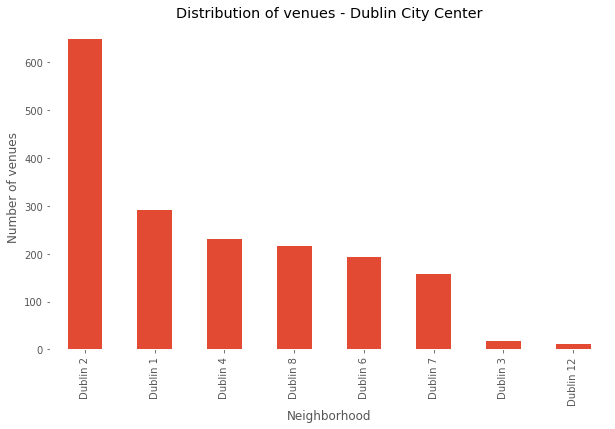

In [22]:
dub_v_count.sort_values('Venue', ascending=False, inplace=True)

mpl.style.use('ggplot') # optional: for ggplot-like style
ax = dub_v_count.plot(kind='bar', figsize=(10, 6))

ax.set_facecolor('white') # remove background
ax.get_legend().remove() # remove legend
plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('Distribution of venues - Dublin City Center') # add title to the plot

plt.show()

#### Clustering the venues for a visual representation on a map

In [23]:
# let's start again with a clean copy of the map of Dublin
dublin_venues_map = folium.Map(location = [dub_latitude, dub_longitude], zoom_start = 13)
# instantiate a mark cluster object for the incidents in the dataframe
category = plugins.MarkerCluster().add_to(dublin_venues_map)
# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(dub_v['Venue Latitude'], dub_v['Venue Longitude'], dub_v['Venue Category']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(category)
# display map
dublin_venues_map

#### Unique categories from all the returned venues

In [52]:
print('There are {} unique categories.'.format(len(dub_v['Venue Category'].unique())))

There are 76 uniques categories.


In [53]:
dub_v_cat = dub_v.groupby('Venue Category').count()
dub_v_cat.drop(columns=['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude', 'Neighborhood'], inplace=True)
dub_v_cat.sort_values(by='Venue', ascending=False).head(10)

Venue
Venue Category             
Café                    597
Restaurant              304
Pizza Place             171
Sandwich Place          160
Italian Restaurant      151
Fast Food Restaurant    138
Indian Restaurant        97
Bakery                   96
Chinese Restaurant       91
French Restaurant        74

#### Bar Chart - Distribution of Top 25 Venues Categories - Dublin City Center

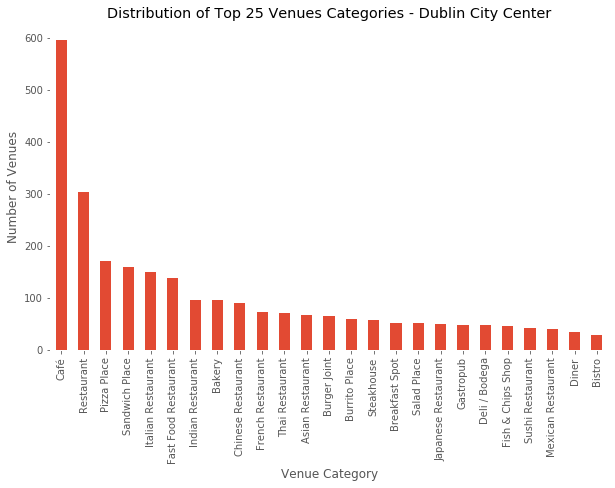

In [54]:
dub_v_cat.sort_values('Venue', ascending=False, inplace=True)
dub_v_cat_top = dub_v_cat.iloc[0:25, :]

mpl.style.use('ggplot') # optional: for ggplot-like style
ax = dub_v_cat_top.plot(kind='bar', figsize=(10, 6))

ax.set_facecolor('white') # remove background
ax.get_legend().remove() # remove legend
plt.xlabel('Venue Category') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Distribution of Top 25 Venues Categories - Dublin City Center') # add title to the plot

plt.show()

#### Cleaning Data / Removing duplicates

In [55]:
dub_t_clean = dub_v.drop_duplicates(['Venue Latitude', 'Venue Longitude', 'Venue'], keep='first')

In [56]:
dub_t_clean.shape

(1111, 7)

In [66]:
dub_t_clean.to_csv('Foursquare_Dublin_Venues_updated_clean.csv', index=False)

In [57]:
dub_v_cat = dub_t_clean.groupby('Venue Category').count()
dub_v_cat.drop(columns=['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude', 'Neighborhood'], inplace=True)
dub_v_cat.sort_values(by='Venue', ascending=False).head(10)

Venue
Venue Category             
Café                    210
Restaurant              110
Pizza Place              57
Sandwich Place           56
Fast Food Restaurant     55
Italian Restaurant       47
Chinese Restaurant       36
Indian Restaurant        35
Bakery                   33
Asian Restaurant         26

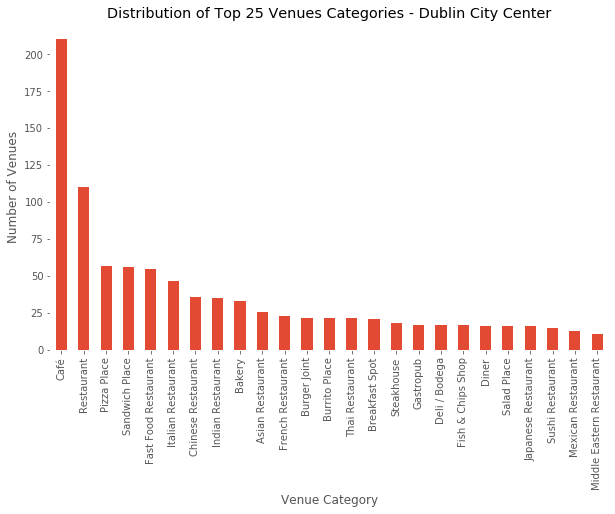

In [58]:
dub_v_cat.sort_values('Venue', ascending=False, inplace=True)
dub_v_cat_top = dub_v_cat.iloc[0:25, :]

mpl.style.use('ggplot') # optional: for ggplot-like style
ax = dub_v_cat_top.plot(kind='bar', figsize=(10, 6))

ax.set_facecolor('white') # remove background
ax.get_legend().remove() # remove legend
plt.xlabel('Venue Category') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Distribution of Top 25 Venues Categories - Dublin City Center') # add title to the plot

plt.show()

In [59]:
import folium
dub_latitude = '53.341785'
dub_longitude = '-6.265288'
# create map of Dublin using latitude and longitude values
map_dublin = folium.Map(location=[dub_latitude, dub_longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(dub_v['Venue Latitude'], dub_v['Venue Longitude'], dub_v['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dublin)

map_dublin

### <center><a href="./2.Research_Dublin_City_Google_Places_API.ipynb">NEXT CHAPTER</a></center>

#### <center> <a href="./0.Table_of_Contents_Code.ipynb">Table of Contents</a><br></center>